### Exercise on Gravity Waves
- Write a program to integrate the gravity wave equations
\begin{align}
\frac{\partial u}{\partial t} + \frac{\partial \phi}{\partial x} & = 0 \quad \quad \mathrm{momentum} \nonumber \\
\frac{\partial \phi}{\partial t} + \Phi \frac{\partial u}{\partial x} & = 0 \quad \quad \mathrm{mass} \nonumber
\end{align}
using discretization 
\begin{align}
\frac{u^{n+1}_{j} - u_{j}^{n-1}}{2\Delta t} + \frac{\phi^{n}_{j+1} - \phi^{n}_{j-1}}{2\Delta x} & = 0 \nonumber \\
\frac{\phi^{n+1}_{j} - \phi^{n-1}_{j}}{2\Delta t} + \Phi \frac{u^{n}_{j+1} - u_{j-1}^{n}}{2\Delta x}  & = 0 \nonumber
\end{align}
and
\begin{align}
\frac{u^{n+1}_{j} - u_{j}^{n}}{\Delta t} + \frac{\phi^{n}_{j+1} - \phi^{n}_{j-1}}{2\Delta x} & = 0 \nonumber \\
\frac{\phi^{n+1}_{j} - \phi^{n}_{j}}{\Delta t} + \Phi \frac{u^{n+1}_{j+1} - u_{j-1}^{n+1}}{2\Delta x}  & = 0 \nonumber
\end{align}
in the domain $0 \leq x \leq 1000\,m$ with mean height of the system such that $\Phi = gH = 1\,m^2/s^2$. Let $\delta x = 0.5\,m$ and assume periodic boundary conditions. Assume the initial shape to be
\begin{align}
    \phi(x, 0) & = \left\{\begin{array}{ll}
      0.0 \quad \mathrm{for} \quad x < 400 \\
      \sin^{2}(((x-400)/200)*\pi) \quad \mathrm{for} \quad 400 \leq x \leq 600 \\
      0.0 \quad \mathrm{for} \quad x > 600
\end{array} \right.
\end{align}

- Integrate forward and show solutions from $t=0\,s$ to $t = 2000\,s$ every $200\,s$ and explain the characteristics of the solution.

**Attention: Select $\Delta t$ to have a stable scheme remembering the CFL condition!**

In [4]:
import numpy as np
import matplotlib.pyplot as plt

In [39]:
class GravityWaves:
    def __init__(self, x0, x1, t0, t1, dx, dt, tp, Phi):
        self.x0 = x0  
        self.x1 = x1 
        self.t0 = t0
        self.t1 = t1
        self.dx = dx
        self.dt = dt
        self.tp = tp
        self.dtdx = dt/dx
        self.Phi = Phi
        self.c = np.sqrt(self.Phi)*self.dtdx
        self.nx = round((x1 - x0) / dx) + 1
        self.x = np.linspace(x0, x1, self.nx)
        self.phi = np.array([self.phi0(xi) for xi in self.x])
        self.phi_old = np.copy(self.phi)
        self.phi_now = np.copy(self.phi)
        self.u_old = np.zeros_like(self.phi)
        self.u_now = np.zeros_like(self.phi)        

    def phi0(self, x):
        if x < 400.0 or x > 600.0:
            return 0.0
        else:
            return (np.sin(((x-400)/200)*np.pi))**2

    def ueq_ft(self, u_now, phi_now):
        return u_now - 0.5*self.dtdx*(np.roll(phi_now, -1) - np.roll(phi_now, 1))

    def peq_ft(self, u_now, phi_now):
        return phi_now - 0.5*self.c*(np.roll(u_now, -1) - np.roll(u_now, 1))

    def ueq(self, u_old, phi_now):
        return u_old - self.dtdx*(np.roll(phi_now, -1) - np.roll(phi_now, 1))
        
    def peq(self, u_now, phi_old):
        return phi_old - self.c*(np.roll(u_now, -1) - np.roll(u_now, 1))
    
    def ueq_fo(self, u_now, phi_now):
        return u_now - 0.5*self.dtdx*(np.roll(phi_now, -1) - np.roll(phi_now, 1))  

    def peq_fo(self, u_fut, phi_now):
        return phi_now - self.c*0.5*(np.roll(u_fut, -1) - np.roll(u_fut, 1)) 
    
    def plot(self, method='M1'):
        t = self.t0

        # Create subplots
        fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 7.5))  # Width=10 inches, Height=5 inches

        if method == 'M1' or method == 'm1':
            self.phi_now = self.peq_ft(self.u_old, self.phi_old)   
            self.u_now = self.ueq_ft(self.u_old, self.phi_old) 
        elif method == 'M2' or method == 'm2':
            self.u_now = self.ueq_fo(self.u_old, self.phi_old)   
            self.phi_now = self.peq_fo(self.u_now, self.phi_old)  
        
        #Plotting the first plot
        ax1.plot(self.x, self.phi_now, label=f'$\phi$({int(t)} s)')
        ax2.plot(self.x, self.u_now, label=f'$\phi$({int(t)} s)')
        t = self.t0 + dt
        while t < self.t1:
            if method == 'M1' or method == 'm1':
                u_new = self.ueq(self.u_old, self.phi_now)
                phi_new = self.peq(self.u_now, self.phi_old)
                self.phi_old[:] = self.phi_now
                self.phi_now[:] = phi_new  
                self.u_old[:] = self.u_now
                self.u_now[:] = u_new 
            elif method == 'M2' or method == 'm2':
                u_new = self.ueq_fo(self.u_now, self.phi_now)
                phi_new = self.peq_fo(u_new, self.phi_now)
                self.phi_now[:] = phi_new  
                self.u_now[:] = u_new
                
            t += self.dt
            if np.mod(t, self.tp) < self.dt:
                ax1.plot(self.x, self.phi_now, label=f'$\phi$({int(t)} s)')
                ax2.plot(self.x, self.u_now, label=f'$u$({int(t)} s)')
            
        fig.suptitle(f'Gravity Waves - {method} \n $u(x, 0) = 0, \Delta t = ${self.dt}')
        #fig.suptitle(f'Gravity Waves, \u(x, 0) = 0, \Delta t = {self.dt}', fontsize=13)
        #fig.set(rf'$\u(x, 0) = 0$, $\Delta t =$ {self.dt}')
        #ax2.set_title(rf'$\u(x, 0) = 0$, $\Delta t =$ {self.dt}')
        #ax1.set_title(rf'$\u(x, 0) = 0$, $\Delta t =$ {self.dt}')
        #ax2.set_title(rf'$\u(x, 0) = 0$, $\Delta t =$ {self.dt}')
        ax1.legend(loc='upper right', fontsize='medium', bbox_to_anchor=(1.25, 1))
        ax2.legend(loc='upper right', fontsize='medium', bbox_to_anchor=(1.25, 1))
        #ax1
        
        #ax1.xlabel('x')
        #ax2.xlabel('x')
        #plt.title(rf'Gravity Waves, $\u(x, 0) = 0$, $\Delta t =$ {self.dt}', fontsize=13)
        plt.tight_layout()  # Ensures everything fits properly
        #ax2.tight_layout()
        plt.savefig(f'GravityWaves{method}, Delta t = {self.dt}.png')
        plt.show()

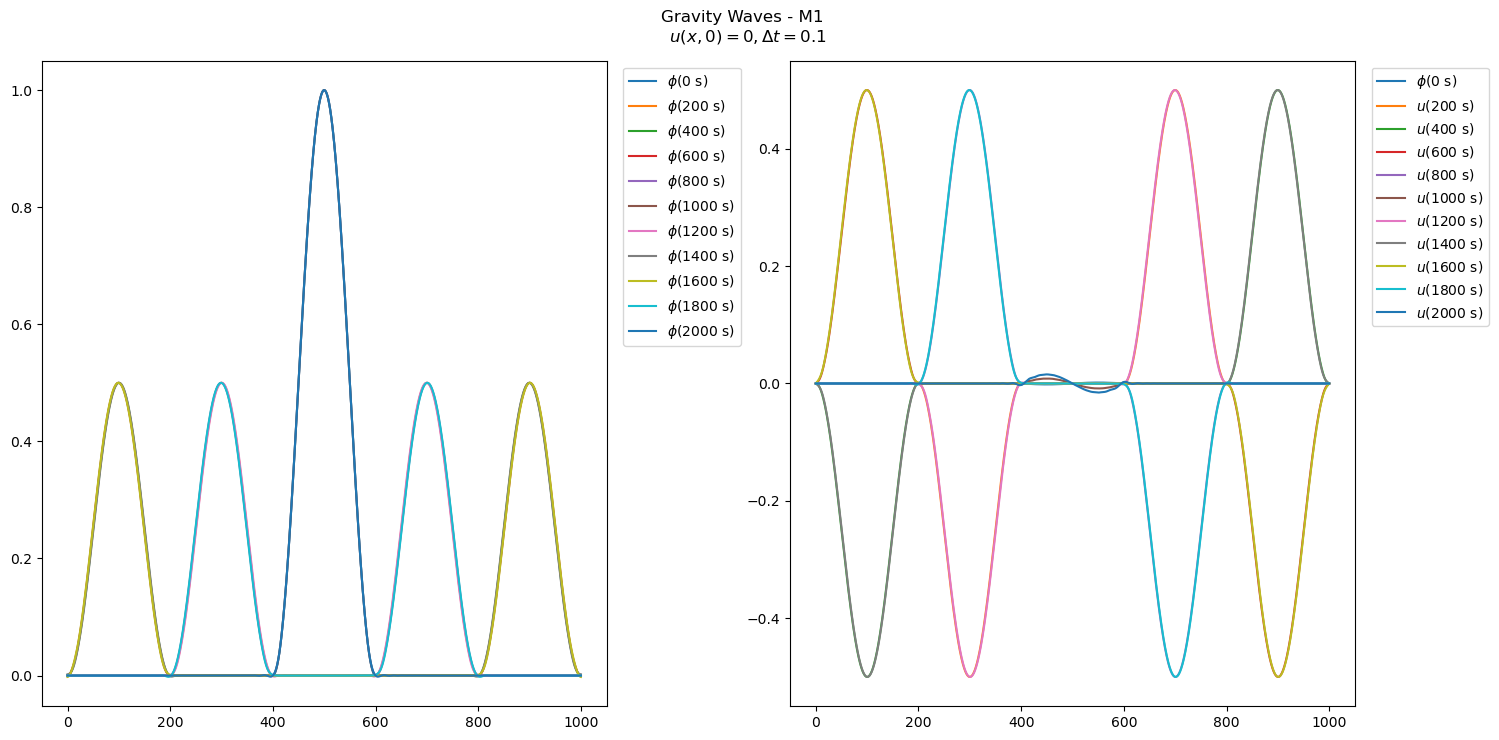

In [40]:
# Define parameters
x0 = 0.0
x1 = 1000.0
t0 = 0.0
t1 = 2000.0
dx = 0.5
dt = 0.1
tp = 200.0
Phi = 1

# Create and plot
GravityWaves(x0, x1, t0, t1, dx, dt, tp, Phi).plot()

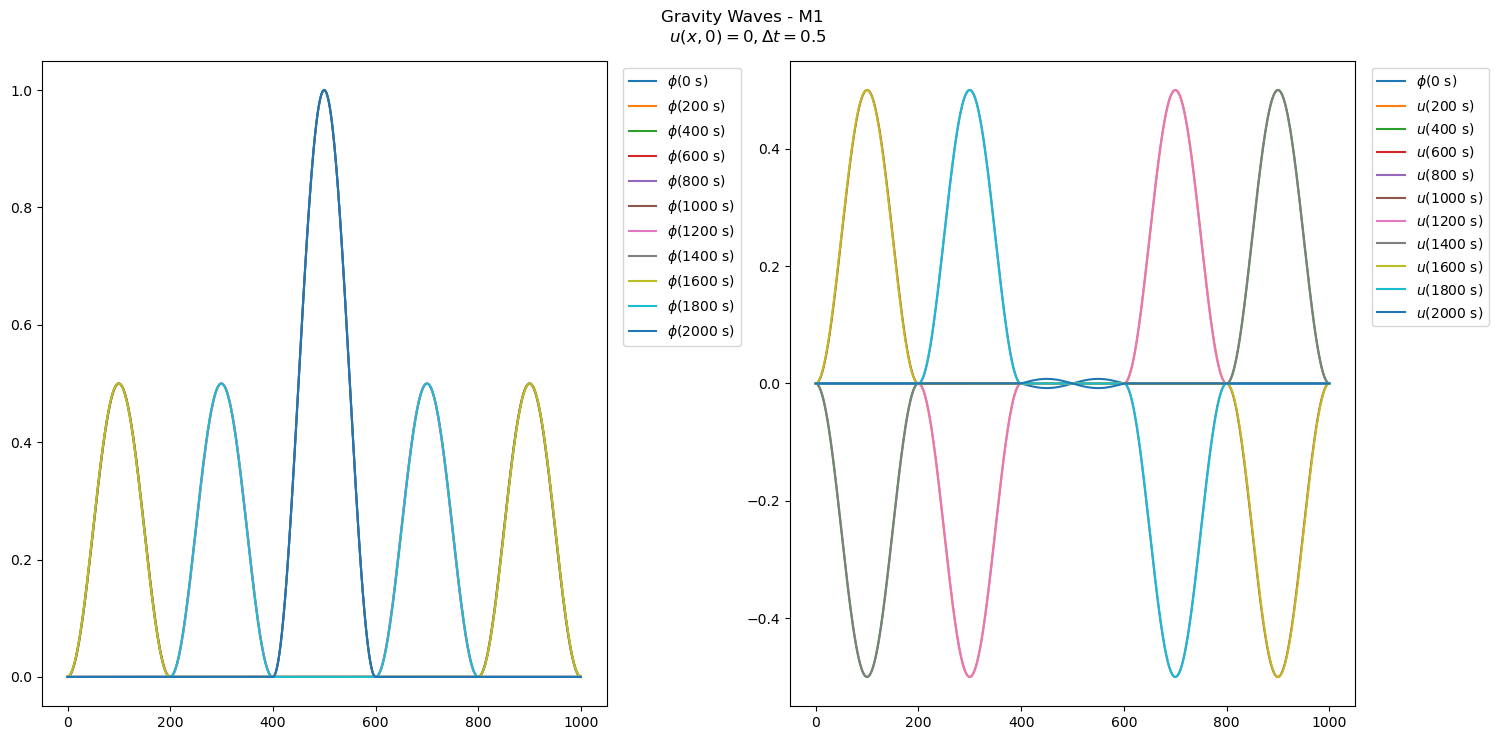

In [50]:
GravityWaves(x0, x1, t0, t1, dx, dx, tp, Phi).plot()

In [51]:
GravityWaves(x0, x1, t0, t1, dx, dx+.1, tp, Phi).plot()

# error for dt > dx

/tmp/ipykernel_5089/3420433834.py:34: RuntimeWarning: overflow encountered in multiply
  return u_old - self.dtdx*(np.roll(phi_now, -1) - np.roll(phi_now, 1))
/tmp/ipykernel_5089/3420433834.py:34: RuntimeWarning: overflow encountered in subtract
  return u_old - self.dtdx*(np.roll(phi_now, -1) - np.roll(phi_now, 1))
/tmp/ipykernel_5089/3420433834.py:37: RuntimeWarning: overflow encountered in subtract
  return phi_old - self.c*(np.roll(u_now, -1) - np.roll(u_now, 1))
/tmp/ipykernel_5089/3420433834.py:37: RuntimeWarning: overflow encountered in multiply
  return phi_old - self.c*(np.roll(u_now, -1) - np.roll(u_now, 1))
/tmp/ipykernel_5089/3420433834.py:34: RuntimeWarning: invalid value encountered in subtract
  return u_old - self.dtdx*(np.roll(phi_now, -1) - np.roll(phi_now, 1))
/tmp/ipykernel_5089/3420433834.py:37: RuntimeWarning: invalid value encountered in subtract
  return phi_old - self.c*(np.roll(u_now, -1) - np.roll(u_now, 1))


IndexError: index 0 is out of bounds for axis 0 with size 0

Error in callback <function _draw_all_if_interactive at 0x7f6d4a7234c0> (for post_execute), with arguments args (),kwargs {}:


IndexError: index 0 is out of bounds for axis 0 with size 0

IndexError: index 0 is out of bounds for axis 0 with size 0

<Figure size 1500x750 with 2 Axes>

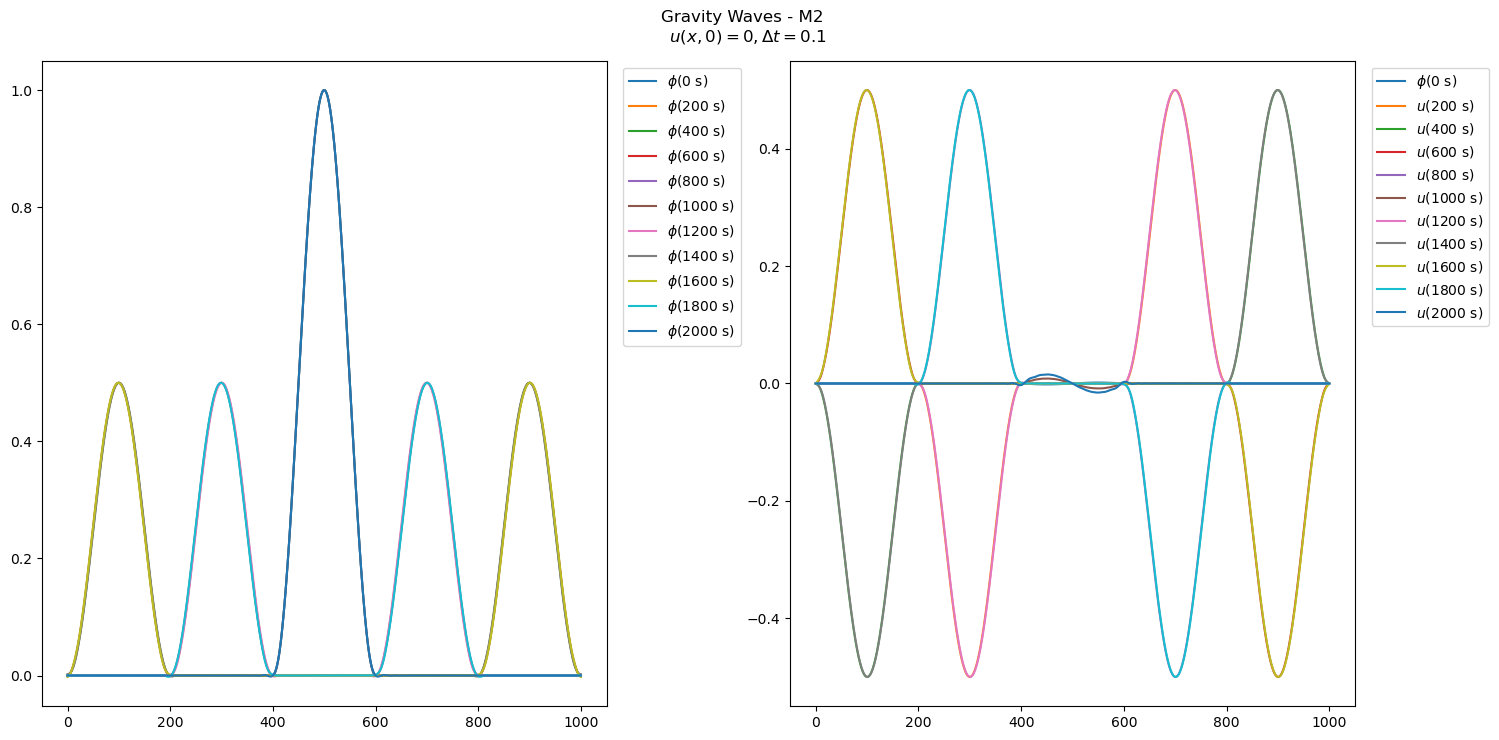

In [43]:
GravityWaves(x0, x1, t0, t1, dx, dt, tp, Phi).plot(method = 'M2')

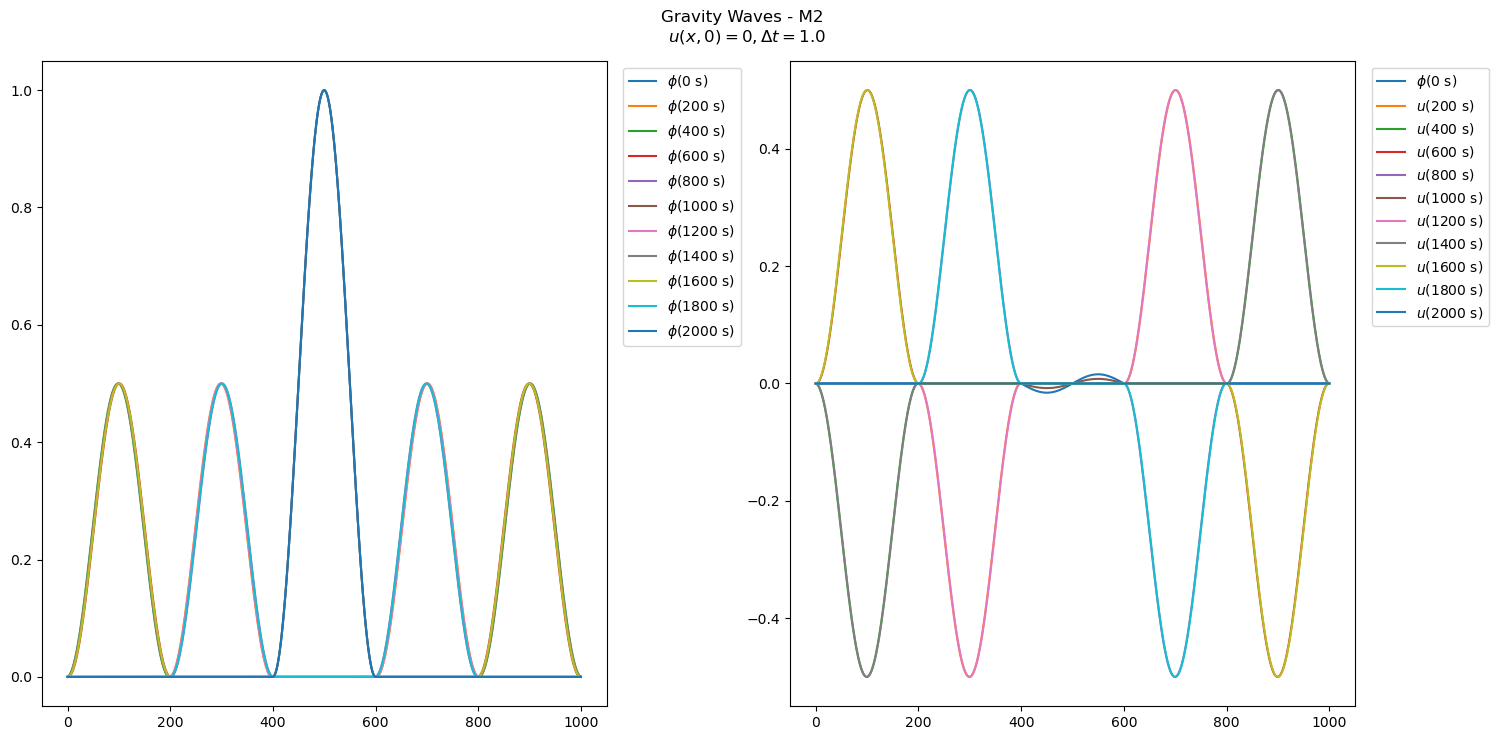

In [42]:
GravityWaves(x0, x1, t0, t1, dx, 1.0, tp, Phi).plot(method = 'M2')

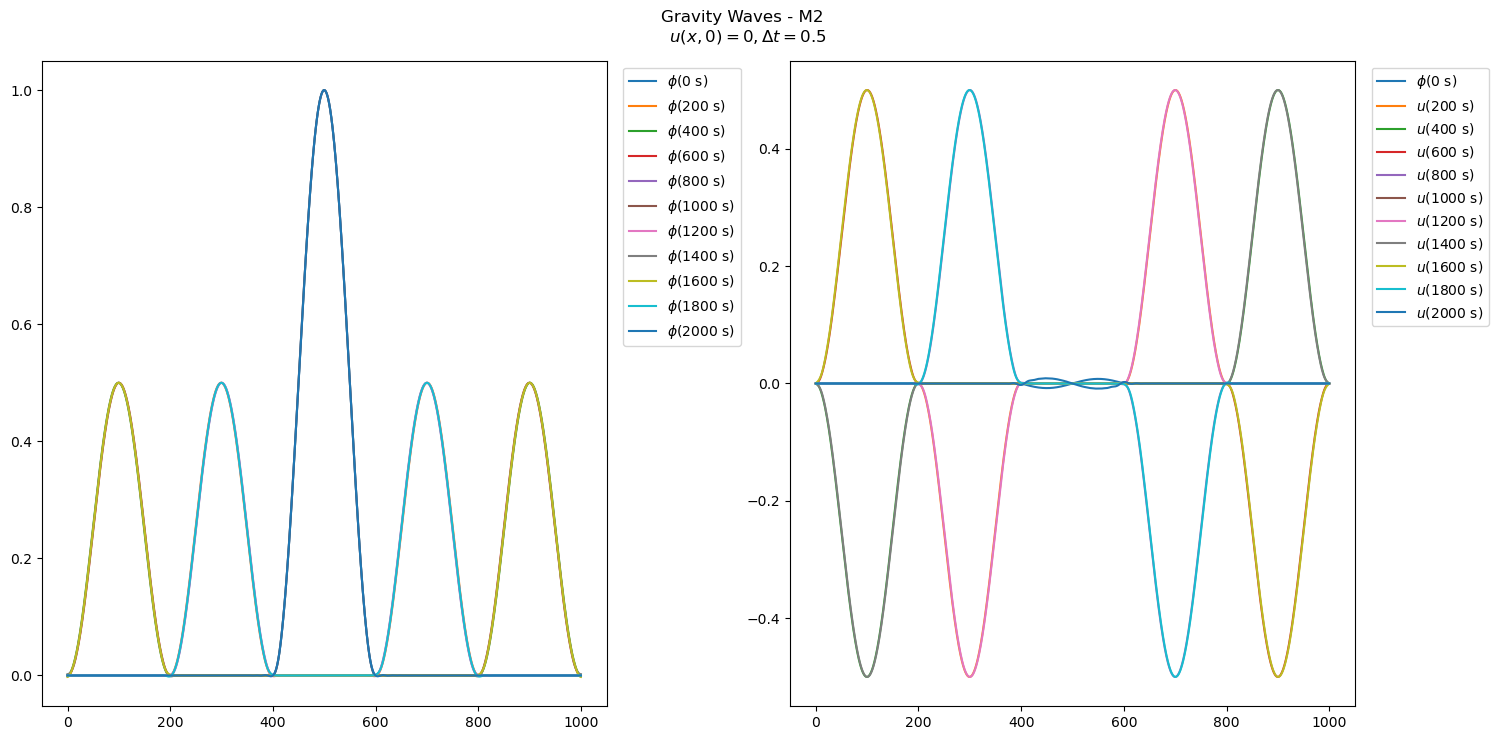

In [49]:
GravityWaves(x0, x1, t0, t1, dx, .5, tp, Phi).plot(method = 'M2')

/tmp/ipykernel_5089/3420433834.py:43: RuntimeWarning: overflow encountered in subtract
  return phi_now - self.c*0.5*(np.roll(u_fut, -1) - np.roll(u_fut, 1))
/tmp/ipykernel_5089/3420433834.py:43: RuntimeWarning: overflow encountered in multiply
  return phi_now - self.c*0.5*(np.roll(u_fut, -1) - np.roll(u_fut, 1))
/tmp/ipykernel_5089/3420433834.py:40: RuntimeWarning: overflow encountered in subtract
  return u_now - 0.5*self.dtdx*(np.roll(phi_now, -1) - np.roll(phi_now, 1))
/tmp/ipykernel_5089/3420433834.py:40: RuntimeWarning: overflow encountered in multiply
  return u_now - 0.5*self.dtdx*(np.roll(phi_now, -1) - np.roll(phi_now, 1))
/tmp/ipykernel_5089/3420433834.py:43: RuntimeWarning: invalid value encountered in subtract
  return phi_now - self.c*0.5*(np.roll(u_fut, -1) - np.roll(u_fut, 1))
/tmp/ipykernel_5089/3420433834.py:40: RuntimeWarning: invalid value encountered in subtract
  return u_now - 0.5*self.dtdx*(np.roll(phi_now, -1) - np.roll(phi_now, 1))


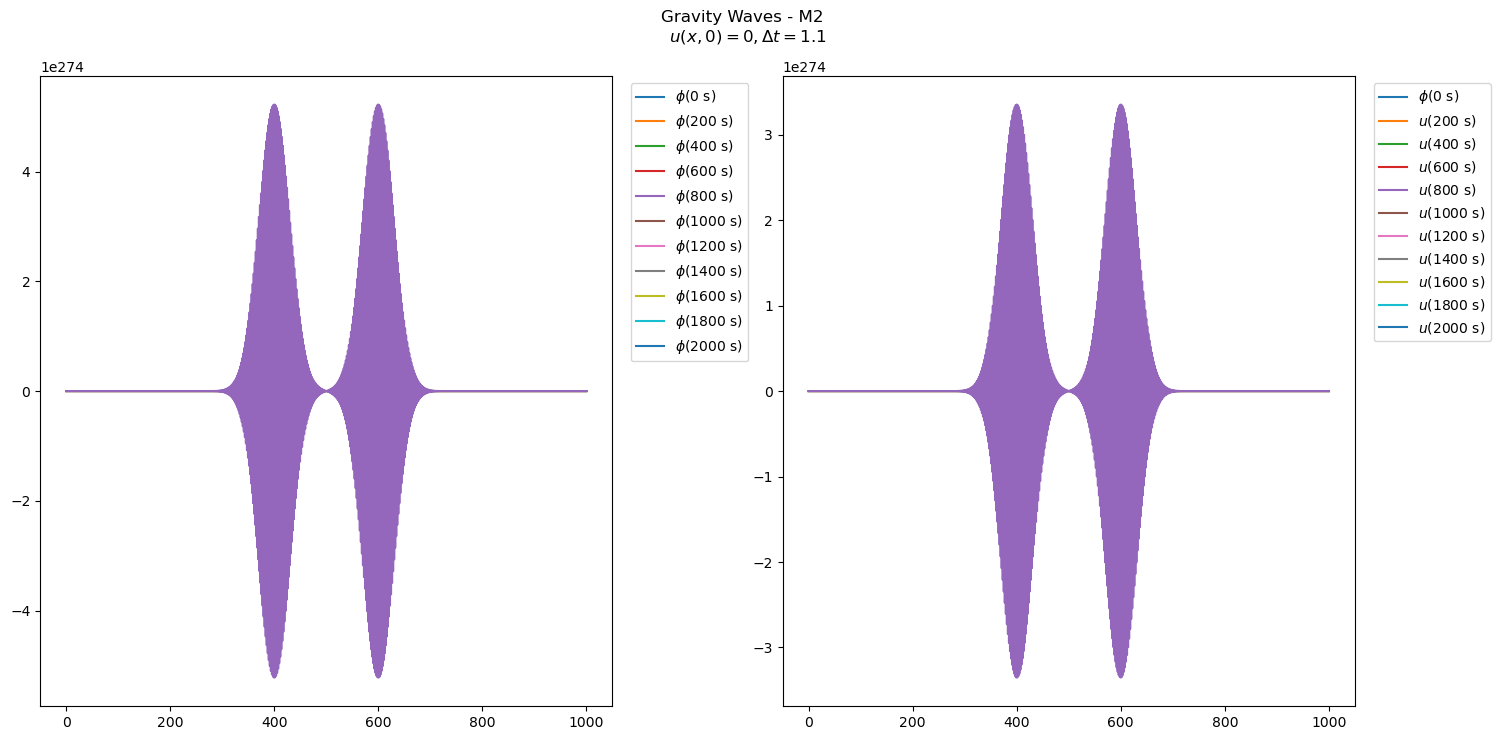

In [52]:
GravityWaves(x0, x1, t0, t1, dx, 1.1, tp, Phi).plot(method = 'M2')

#error since c > 2, which give unstable solution